# Poisson Kriging - Area to Point Kriging

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Build point-based map of better spatial resolution.

## Level: Advanced

## Changelog

| Date | Change description | Author         |
|------|--------------------|----------------|
| 2022-08-27 | The tutorial was updated for the 0.3.0 version of the package | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

To start this tutorial, it is required to understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials. The good idea is to end **Poisson Kriging - Centroid based** and **Poisson Kriging - Area to Area** tutorials before this one.

The Poisson Kriging technique is used to model spatial count data. We are analyzing a particular case where data is counted over areas. Those areas may have irregular shapes and sizes because they represent administrative regions.

We will transform the areal rates of Breast Cancer in the Northeastern US counties into representative population blocks (point support).

> The breast cancer rates data and the point support population counts are located in the geopackage in a directory: `samples/regularization/cancer_data.gpkg`.

The tutorial covers the following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Perform Area to Point smoothing of areal data.
4. Visualize points.

## 1) Read and explore data

In [1]:
import numpy as np

from pyinterpolate import TheoreticalVariogram
from pyinterpolate import Blocks, PointSupport
from pyinterpolate import smooth_blocks

<AxesSubplot:>

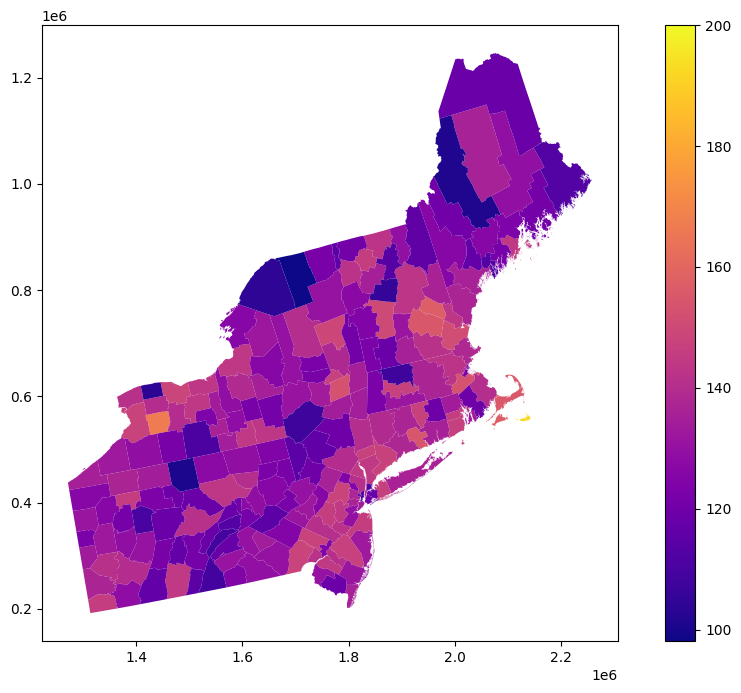

In [2]:
DATASET = 'samples/regularization/cancer_data.gpkg'
OUTPUT = 'samples/regularization/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

blocks = Blocks()
blocks.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

point_support = PointSupport()
point_support.from_files(point_support_data_file=DATASET,
                         blocks_file=DATASET,
                         point_support_geometry_col=GEOMETRY_COL,
                         point_support_val_col=POP10,
                         blocks_geometry_col=GEOMETRY_COL,
                         blocks_index_col=POLYGON_ID,
                         use_point_support_crs=True,
                         point_support_layer_name=POPULATION_LAYER,
                         blocks_layer_name=POLYGON_LAYER)

# Lets take a look into a map of areal counts

blocks.data.plot(column=blocks.value_column_name, cmap='plasma', vmax=200, legend=True, figsize=(12, 8))

**Clarification**: It is a good idea to look into the spatial patterns in a dataset and to visually check if our data do not have any NaN values. We use the geopandas `GeoDataFrame.plot()` function with a color map that diverges regions based on the cancer incidence rates. The output choropleth map is not ideal, and (probably) it has a few unreliable results, for example:

- in counties with a small population, where the ratio number of cases to population size is high even if the number of cases is low,
- counties that are very big and sparsely populated may draw more of our attention instead of densely populated counties,
- transitions of colors (rates) between counties may be too abrupt, even if we know, that neighboring counties should have closer results.

We can overcome those problems using Area-to-Point Kriging. Deconvoluted choropleth map is smoother than the colored polygon representation, and places where population is equal to zero are not included in the mapping.

## 2) Load semivariogram model

In this step, we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regularization along with the Poisson Kriging, but it is a very long process, and it is more convenient to separate those two steps.

In [3]:
semivariogram = TheoreticalVariogram()  # Create TheoreticalSemivariogram object
semivariogram.from_json('output/regularized_model.json')  # Load regularized semivariogram

## 3) Perform Area to Point smoothing of areal data.

The process of map smoothing is straightforward. We use the `smooth_blocks()` function and pass into it a block and their point support. We pass into the function two interesting parameters:

- The `number_of_neighbors` (the most crucial parameter - how many neighbors are affecting your analysis area).
- The `crs` (Coordinate Reference System). We may leave it as the `None`, but then returned `GeoDataFrame` won’t have **CRS**. Be careful! The function doesn’t check if passed **CRS** is valid for given blocks and point support!

The method returns `GeoDataFrame` with points and predicted values. It iteratively re-calculates each area risk and produces predictions per point. In Area to Area Kriging, those predictions are aggregated. Now we leave them and use them as a smooth map of areal risk.

In [4]:
smoothed = smooth_blocks(semivariogram_model=semivariogram,
                         blocks=blocks,
                         point_support=point_support,
                         number_of_neighbors=16,
                         max_range=10000,
                         crs=blocks.data.crs,
                         raise_when_negative_error=False,
                         raise_when_negative_prediction=True)

  7%|██▉                                       | 15/217 [00:01<00:19, 10.44it/s]/home/szymon/miniconda3/envs/p39/lib/python3.9/site-packages/pyinterpolate/kriging/models/block/weight.py:182: RuntimeWarning: invalid value encountered in double_scalars
  weighted_block_smv = weighted_semivars / np.sum(all_weights)
100%|█████████████████████████████████████████| 217/217 [00:33<00:00,  6.54it/s]


In [5]:
smoothed.head()

,area id,geometry,pred,err
0,25019.0,POINT (2117322.312 556124.507),0.090620,10.362956
1,25019.0,POINT (2134642.820 556124.507),167.450133,7.179673
2,36121.0,POINT (1424501.989 556124.507),NaN,NaN
3,36121.0,POINT (1424501.989 546124.507),NaN,NaN
4,36121.0,POINT (1433162.243 561124.507),NaN,NaN


## 4) Visualize data

The last step is data visualization. We use a choropleth map from the GeoPandas package, but you can store smoothed map to a spatial file of points and process it in a different place or with specific software (in our idea, the best for it is **QGIS**).

<AxesSubplot:>

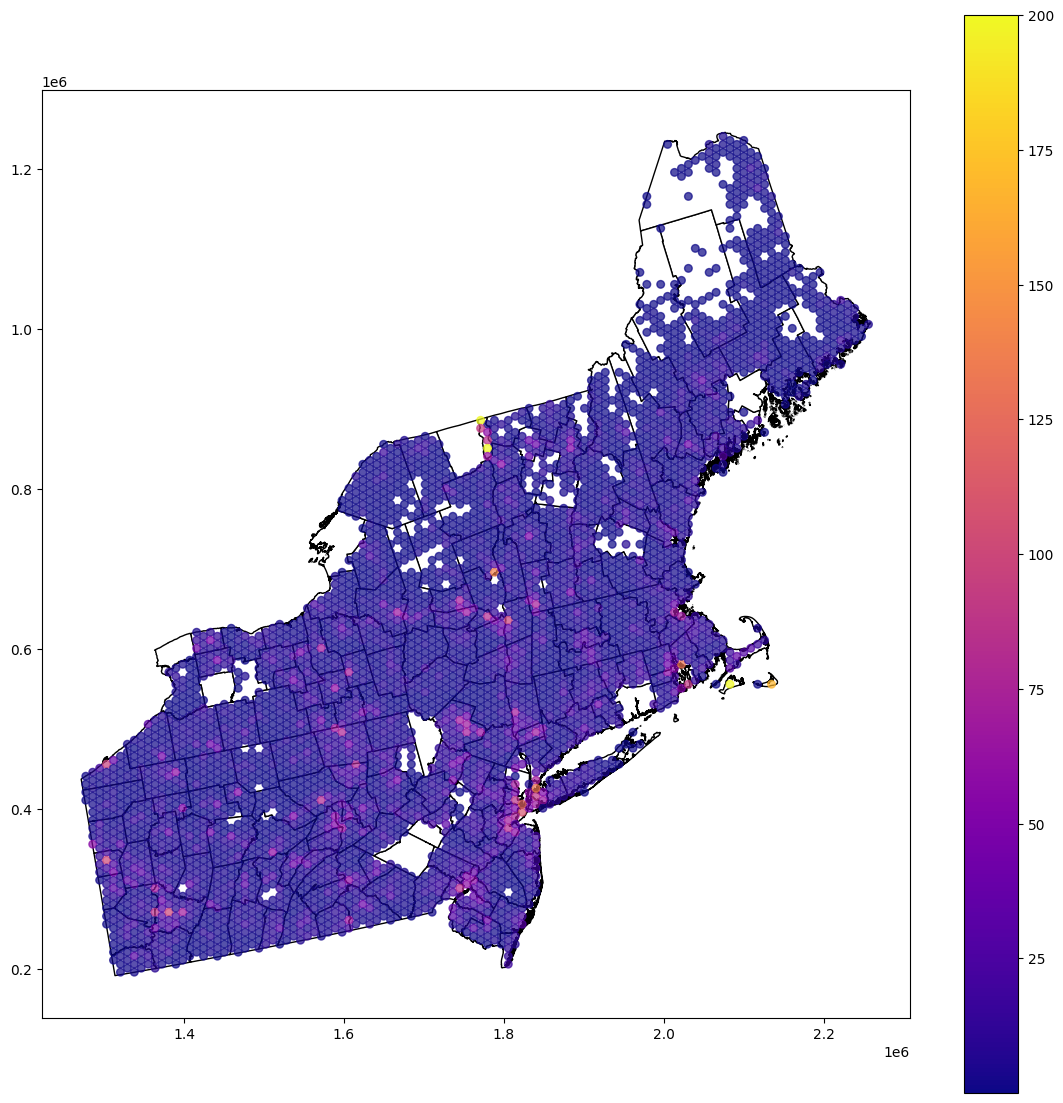

In [6]:
base = blocks.data.plot(figsize=(14, 14), color='white', edgecolor='black')
smooth_plot_data = smoothed.copy()
smooth_plot_data[smooth_plot_data['pred'] == 0] = np.nan
smooth_plot_data.plot(ax=base, column='pred', cmap='plasma', legend=True, markersize=30, vmax=200, alpha=0.7)

---